# Poc utilizando KNN para trabalho de conclusão de Ciência da computação da Feevale
## Carrega JSON

In [3]:
import json

users = {}

with open('spotify-plugin-app-export.json') as json_file:
    data = json.load(json_file)

    for userKey in data['events'].keys():
        user = data['events'][userKey]
        userEvents = []

        for key in user.keys():
            userEvents.append(user[key])

        users[userKey] = userEvents


for userKey in users.keys():
    print(f"len({userKey}) => {len(users[userKey])}")

len(spotify:user:16nxkn6lmlix2ou2w2rvodu3n) => 9
len(spotify:user:226rxsqefx3heakyeln7t3unq) => 27
len(spotify:user:22iwjt6kc4zv74sq7cutkhtwy) => 9
len(spotify:user:3152wu7mz2aoxfrg5mtqov77lseu) => 19
len(spotify:user:31bfdxg5fe2335adqfcg4xpugpcq) => 10
len(spotify:user:3ka2awymoso1wgdlwuq50uz8h) => 16
len(spotify:user:4i3jdhv6vubcjdpwsn38iv8u4) => 376
len(spotify:user:8q3uk0rwypu5r7dsq48476qak) => 5
len(spotify:user:andressltz) => 162
len(spotify:user:b8r2mhyhep5t0np1keaqmvvi0) => 20
len(spotify:user:gabrielcartelli) => 3
len(spotify:user:ggkonzen) => 12
len(spotify:user:iisa1999) => 326
len(spotify:user:iortim) => 174
len(spotify:user:jyangalonga) => 229
len(spotify:user:maiconunzer) => 7
len(spotify:user:o16tnkq56zdt2obwii1vgbs4o) => 5
len(spotify:user:tiagoterme) => 65


## Separa Contexto

In [4]:
import pandas as pd

usersContexts = {}

contexts = []
currentCtx = None

for event in users['spotify:user:4i3jdhv6vubcjdpwsn38iv8u4']:
    if event['action'] == "CHOOSE_FEELING":
        if currentCtx:
            contexts.append(currentCtx)

        currentCtx = {"musics": [], "info": {"feeling": event['value']}}
    elif event['action'] == "CHOOSE_ACTIVITY":
        currentCtx['info']['activity'] = event['value']
    elif event['action'] == "CHOOSE_LOCATION":
        currentCtx['info']['location'] = event['value']
    elif event['action'] == "LOAD_LOCATION":
        # currentCtx['info']['loaded_location'] = event['value']
        a = 0
    else:
        currentCtx['musics'].append(event)

contexts.append(currentCtx)

df=pd.DataFrame(contexts)

df.head()

musics  \
0  [{'action': 'PLAY_MUSIC', 'createdDateTime': '...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

                                                info  
0  {'feeling': 'feliz;alegre', 'activity': 'estud...  
1  {'feeling': 'feliz', 'activity': 'estudando', ...  
2  {'feeling': 'alegre', 'activity': 'estudando',...  
3  {'feeling': 'feliz', 'activity': 'estudando', ...  
4  {'feeling': 'alegre;animada', 'activity': 'est...

## Separa contexto das musicas

In [5]:
musicTable = []
currentMusicCtx = None
lastMusic = None

for ctx in contexts:
    for music in ctx['musics']:
        if music['value'] != lastMusic:
            if lastMusic:
                currentMusicCtx.update(ctx['info'])
                musicTable.append(currentMusicCtx)
            
            lastMusic = music['value']
            currentMusicCtx = {'uri': music['value'], 'like': 0, 'hate':0, 'restart':0}

        if music['action'] == 'LIKED_MUSIC':
            currentMusicCtx['like'] += 1
        elif music['action'] == 'HATED_MUSIC':
            currentMusicCtx['hate'] += 1
        elif music['action'] == 'RESTART_MUSIC':
            currentMusicCtx['restart'] += 1

    currentMusicCtx.update(ctx['info'])
    musicTable.append(currentMusicCtx)


dfm=pd.DataFrame(musicTable)

dfm.head()

uri  like  hate  restart       feeling  \
0  spotify:track:29aSfWddeZJCfnrcMb20sy     1     0        0  feliz;alegre   
1  spotify:track:2evFJQfQVcDEXyOiyEV6OW     0     0        0  feliz;alegre   
2  spotify:track:6Te1vrlCz4DdCeONagkT6j     0     0        1  feliz;alegre   
3  spotify:track:5YrMcUZoNXlUCfwgnfocgL     0     0        0  feliz;alegre   
4  spotify:track:120w1eBYfiYrSXtegu6uEb     1     0        0  feliz;alegre   

    activity location  
0  estudando     casa  
1  estudando     casa  
2  estudando     casa  
3  estudando     casa  
4  estudando     casa

## busca informações das musicas

In [6]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv # add this line

load_dotenv() # add this line

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=os.getenv('SPOTIFY_CLIENT_ID'),
                                                           client_secret=os.getenv('SPOTIFY_CLIENT_SECRET')))

musicsIds = list(map(lambda x : x['uri'], musicTable))

tracks = []
tracksMap = {}

i = 0

while i < len(musicsIds):
    ids = musicsIds[i:i + 50]
    response = sp.tracks(ids)
    tracks.extend(response['tracks'])
    i += 50

for track in tracks:
    tracksMap[track['uri']] = track

dft=pd.DataFrame(tracksMap)

dft

False   
name                                                 Best I Ever Had   
popularity                                                        52   
preview_url                                                     None   
track_number                                                       2   
type                                                           track   
uri                             spotify:track:120w1eBYfiYrSXtegu6uEb   

                                spotify:track:03nPEoQOYMuDe7KmGljpmd  \
album              {'album_type': 'album', 'artists': [{'external...   
artists            [{'external_urls': {'spotify': 'https://open.s...   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   260000   
explicit                                                        True   
external_ids                                {'isrc': 'USSM11806283'}   
external_urls      {'spotify': 'https://open.spotify.com/track/03...   
href               https://api.spotify.com/v1/tracks/03nPEoQOYMuD...   
id                                            03nPEoQOYMuDe7KmGljpmd   
is_local                                                       False   
name               No Brainer (feat. Justin Bieber, Chance the Ra...   
popularity                                                        66   
preview_url        https://p.scdn.co/mp3-preview/607449ba733224db...   
track_number                                                      13   
type                                                           track   
uri                             spotify:track:03nPEoQOYMuDe7KmGljpmd   

                                spotify:track:6PYnUsNEpYC7A4BS2sjw3L  \
album              {'album_type': 'single', 'artists': [{'externa...   
artists            [{'external_urls': {'spotify': 'https://open.s...   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   254999   
explicit                                                       False   
external_ids                                {'isrc': 'USRC11902029'}   
external_urls      {'spotify': 'https://open.spotify.com/track/6P...   
href               https://api.spotify.com/v1/tracks/6PYnUsNEpYC7...   
id                                            6PYnUsNEpYC7A4BS2sjw3L   
is_local                                                       False   
name                       Right Back (feat. A Boogie Wit Da Hoodie)   
popularity                                                        69   
preview_url        https://p.scdn.co/mp3-preview/276028634b0fdea7...   
track_number                                                       1   
type                                                           track   
uri                             spotify:track:6PYnUsNEpYC7A4BS2sjw3L   

                                spotify:track:50UkypyQJbSQLaXHke5Yep  \
album              {'album_type': 'album', 'artists': [{'external...   
artists            [{'external_urls': {'spotify': 'https://open.s...   
available_markets  [AD, AR, AT, AU, BA, BE, BG, BO, BR, CA, CH, C...   
disc_number                                                        1   
duration_ms                                                   180493   
explicit                                                        True   
external_ids                                {'isrc': 'USUM70503011'}   
external_urls      {'spotify': 'https://open.spotify.com/track/50...   
href               https://api.spotify.com/v1/tracks/50UkypyQJbSQ...   
id                                            50UkypyQJbSQLaXHke5Yep   
is_local                                                       False   
name                                  There It Go (The Whistle Song)   
popularity                  

## busca informações dos artistas (genero)

In [7]:
artistsIds = list(map(lambda x : x['artists'][0]['id'], tracks))

artists = []
artistsMap = {}

i = 0
while i < len(artistsIds):
    ids = artistsIds[i:i + 50]
    response = sp.artists(ids)
    artists.extend(response['artists'])
    i += 50

for artist in artists:
    artistsMap[artist['uri']] = artist

dfa=pd.DataFrame(artistsMap)

dfa

spotify:artist:2IvkS5MXK0vPGnwyJsrEyV  \
external_urls  {'spotify': 'https://open.spotify.com/artist/2...   
followers                       {'href': None, 'total': 2730612}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/2IvkS5MXK0v...   
id                                        2IvkS5MXK0vPGnwyJsrEyV   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                                 Eric Church   
popularity                                                    77   
type                                                      artist   
uri                        spotify:artist:2IvkS5MXK0vPGnwyJsrEyV   

                           spotify:artist:3THMgU4KdL7LlO5TEREs2g  \
external_urls  {'spotify': 'https://open.spotify.com/artist/3...   
followers                        {'href': None, 'total': 436116}   
genres         [country, country road, country rock, oklahoma...   
href           https://api.spotify.com/v1/artists/3THMgU4KdL7...   
id                                        3THMgU4KdL7LlO5TEREs2g   
images         [{'height': 1500, 'url': 'https://i.scdn.co/im...   
name                                                  Joe Diffie   
popularity                                                    64   
type                                                      artist   
uri                        spotify:artist:3THMgU4KdL7LlO5TEREs2g   

                           spotify:artist:6yJCxee7QumYr820xdIsjo  \
external_urls  {'spotify': 'https://open.spotify.com/artist/6...   
followers                       {'href': None, 'total': 2359675}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/6yJCxee7Qum...   
id                                        6yJCxee7QumYr820xdIsjo   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                              Zac Brown Band   
popularity                                                    77   
type                                                      artist   
uri                        spotify:artist:6yJCxee7QumYr820xdIsjo   

                           spotify:artist:37W8SKV5Vc8lcGtdyWCA5m  \
external_urls  {'spotify': 'https://open.spotify.com/artist/3...   
followers                        {'href': None, 'total': 739199}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/37W8SKV5Vc8...   
id                                        37W8SKV5Vc8lcGtdyWCA5m   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                                  Gary Allan   
popularity                                                    62   
type                                                      artist   
uri                        spotify:artist:37W8SKV5Vc8lcGtdyWCA5m   

                           spotify:artist:0QHgL1lAIqAw0HtD7YldmP  \
external_urls  {'spotify': 'https://open.spotify.com/artist/0...   
followers                       {'href': None, 'total': 5229896}   
genres         [dance pop, hip hop, miami hip hop, pop, pop r...   
href           https://api.spotify.com/v1/artists/0QHgL1lAIqA...   
id                                        0QHgL1lAIqAw0HtD7YldmP   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                                   DJ Khaled   
popularity                                                    86   
type                                                      artist   
uri                        spotify:artist:0QHgL1lAIqAw0HtD7YldmP   

                           spotify:artist:6LuN9FCkKOj5PcnpouEgny  \
external_urls  {'spotify': 'https://open.spotify.com/artist/6...   
followers                      {'href': None, 'total': 12740174}   
genres                                    [alternative r&b, pop]   
href      

## adiciona genero a tabela

In [8]:
for music in musicTable:
    artistId = tracksMap[music['uri']]['artists'][0]['uri']

    music['genre'] = artistsMap[artistId]['genres']

dfmg=pd.DataFrame(musicTable)

dfmg.head()

uri  like  hate  restart       feeling  \
0  spotify:track:29aSfWddeZJCfnrcMb20sy     1     0        0  feliz;alegre   
1  spotify:track:2evFJQfQVcDEXyOiyEV6OW     0     0        0  feliz;alegre   
2  spotify:track:6Te1vrlCz4DdCeONagkT6j     0     0        1  feliz;alegre   
3  spotify:track:5YrMcUZoNXlUCfwgnfocgL     0     0        0  feliz;alegre   
4  spotify:track:120w1eBYfiYrSXtegu6uEb     1     0        0  feliz;alegre   

    activity location                                              genre  
0  estudando     casa  [contemporary country, country, country road, ...  
1  estudando     casa  [country, country road, country rock, oklahoma...  
2  estudando     casa  [contemporary country, country, country road, ...  
3  estudando     casa  [contemporary country, country, country road, ...  
4  estudando     casa  [contemporary country, country, country road, ...

## trocar musica por genero

In [9]:
genreTable = []

for music in musicTable:
    for genre in music['genre']:
        newGenre = music.copy()

        del newGenre['uri']
        del newGenre['genre']

        newGenre['genre'] = genre

        genreTable.append(newGenre)

dfg=pd.DataFrame(genreTable)

dfg.head()

like  hate  restart       feeling   activity location                 genre
0     1     0        0  feliz;alegre  estudando     casa  contemporary country
1     1     0        0  feliz;alegre  estudando     casa               country
2     1     0        0  feliz;alegre  estudando     casa          country road
3     1     0        0  feliz;alegre  estudando     casa   modern country rock
4     0     0        0  feliz;alegre  estudando     casa               country

In [10]:
# https://www.allmusic.com/genres
# https://developer.spotify.com/community/showcase/music-popcorn/

genres = {}

with open('genres.json') as json_file:
    data = json.load(json_file)

    for genre in data:
        genres[genre['name']] = genre

genresDF = pd.DataFrame(genres)

genresDF.head()

dance pop  \
sims    [{'name': 'pop', 'similarity': 0.772595}, {'na...   
family                               [pop, electro house]   
name                                            dance pop   
pop                                                    72   

                                                      pop  \
sims    [{'name': 'dance pop', 'similarity': 0.757143}...   
family                                              [pop]   
name                                                  pop   
pop                                                    72   

                                                 pop rock  \
sims    [{'name': 'hot adult contemporary', 'similarit...   
family                                        [pop, rock]   
name                                             pop rock   
pop                                                    57   

                                                  hip hop  \
sims    [{'name': 'rap', 'similarity': 0.67033}, {'nam...   
family                                          [hip hop]   
name                                              hip hop   
pop                                                    51   

                                                  pop rap  \
sims    [{'name': 'southern hip hop', 'similarity': 0....   
family                                     [pop, hip hop]   
name                                              pop rap   
pop                                                    50   

                                                 teen pop  \
sims    [{'name': 'pop', 'similarity': 0.528986}, {'na...   
family                                              [pop]   
name                                             teen pop   
pop                                                    44   

                                                     rock  \
sims    [{'name': 'album rock', 'similarity': 0.571121...   
family                                             [rock]   
name                                                 rock   
pop                                                    43   

                                            electro house  \
sims    [{'name': 'edm', 'similarity': 0.561224}, {'na...   
family                                    [electro house]   
name                                        electro house   
pop                                                    42   

                                                    house  \
sims    [{'name': 'electro house', 'similarity': 0.600...   
family                                    [electro house]   
name                                                house   
pop                                                    42   

                                                      r&b  ...  \
sims    [{'name': 'urban contemporary', 'similarity': ...  ...   
family                                              [r&b]  ...   
name                                                  r&b  ...   
pop                                                    41  ...   

                                            vintage swing  vocaloid  \
sims    [{'name': 'swing', 'similarity': 0.138686}, {'...        []   
family                                             [jazz]   [world]   
name                                        vintage swing  vocaloid   
pop                                                     0         0   

                                            volksmusik  \
sims    [{'name': 'schlager', 'similarity': 0.429268}]   
family                                 [electro house]   
name                                        volksmusik   
pop                                                  0   

                                            wind ensemble  \
sims    [{'name': 'marching band', 'similarity': 0.100...   
family                                            [world]   
name                                        wind ensemble   
pop                                                     0   

          

## tratar generos

In [11]:
for item in genreTable:
    genreName = item['genre']

    if (genreName in genres): # aqui verificamos se existe o genero na lista dos padrões
         item['genre'] = genres[genreName]['family']
    

i = 0

print(f"before genre len({len(genreTable)})")

while i < len(genreTable):
    item = genreTable[i]
    genrelist = item['genre']

    if isinstance(genrelist, list):
        genreTable.pop(i)

        for genre in genrelist:
            copy = item.copy()
            copy['genre'] = genre
            genreTable.insert(i, copy)
    i += 1

print(f"after genre len({len(genreTable)})")

genresDF = pd.DataFrame(genreTable)

genresDF.head()

before genre len(489)
after genre len(606)


like  hate  restart       feeling   activity location         genre
0     1     0        0  feliz;alegre  estudando     casa       country
1     1     0        0  feliz;alegre  estudando     casa       country
2     1     0        0  feliz;alegre  estudando     casa  country road
3     1     0        0  feliz;alegre  estudando     casa          rock
4     1     0        0  feliz;alegre  estudando     casa       country

## Trata contextos duplicados (;)

In [12]:
def trataMultiplosDaColuna(key):
    print(f"before {key} len({len(genreTable)})")

    i = 0

    while i < len(genreTable):
        genre = genreTable[i]
        ctxSplit = genre[key].split(";")
        genreTable.pop(i)

        for ctx in ctxSplit:
            genreCopy = genre.copy()
            genreCopy[key] = ctx
            genreTable.insert(i, genreCopy)

        i += 1

    print(f"after {key} len({len(genreTable)})")


trataMultiplosDaColuna("feeling") 
trataMultiplosDaColuna("activity")
trataMultiplosDaColuna("location")

before feeling len(606)
after feeling len(1035)
before activity len(1035)
after activity len(1385)
before location len(1385)
after location len(1385)


## Trata contextos musicais (multiplos like, hate, restart)

In [13]:
def trataNumericosDaColuna(key):
    print(f"before {key} len({len(genreTable)})")

    i = 0

    while i < len(genreTable):
        genre = genreTable[i]
        
        if genre[key] > 0:
            genreTable.pop(i)

            j = 0

            while j < genre[key]:
                genreCopy = genre.copy()
                genreCopy[key] = 1
                genreTable.insert(i, genreCopy)

                j += 1

        i += 1

    print(f"after {key} len({len(genreTable)})")


trataNumericosDaColuna("like") 
trataNumericosDaColuna("hate")
trataNumericosDaColuna("restart")

dfg=pd.DataFrame(genreTable)

dfg.head()

before like len(1385)
after like len(1751)
before hate len(1751)
after hate len(1775)
before restart len(1775)
after restart len(1775)


like  hate  restart feeling   activity location         genre
0     1     0        0  alegre  estudando     casa       country
1     1     0        0   feliz  estudando     casa       country
2     1     0        0  alegre  estudando     casa       country
3     1     0        0   feliz  estudando     casa       country
4     1     0        0  alegre  estudando     casa  country road

## transformar labels

In [14]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

dfg['feeling'] = le.fit_transform(dfg['feeling'])
dfg['activity'] = le.fit_transform(dfg['activity'])
dfg['location'] = le.fit_transform(dfg['location'])

dfg.head()

like  hate  restart  feeling  activity  location         genre
0     1     0        0        1         2         1       country
1     1     0        0        8         2         1       country
2     1     0        0        1         2         1       country
3     1     0        0        8         2         1       country
4     1     0        0        1         2         1  country road

## plotar

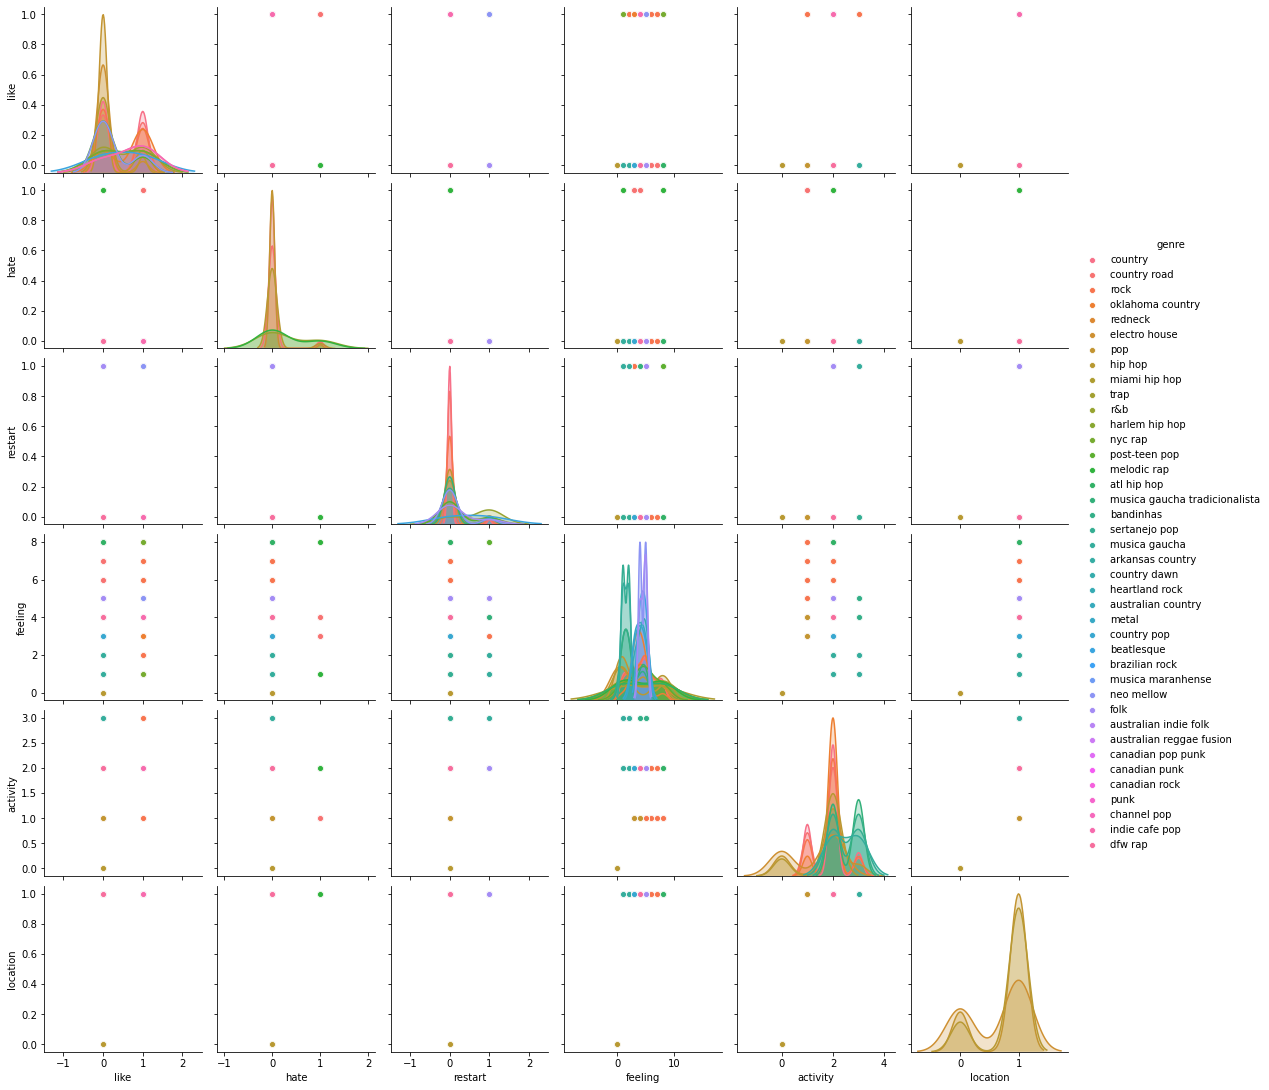

In [13]:
import seaborn as sns

sns.pairplot(dfg, hue="genre")

## Criando as estruturas de parametrização para kvizinhos e kfolds

In [37]:
# Intervalo de números ímpares de 1 a 10 para utilização do k no KNN
listakvizinhos = list(range(1,10,2))
print(listakvizinhos)

[1, 3, 5, 7, 9]


In [38]:
# Intervalo de possíveis valores para k-fold
listakfolds = list(range(10,20))
print(listakfolds)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [39]:
# Estruturas para armazenar os valores dos modelos
listakmodelo = []
listakfoldmodelo = []
listaresultadosmodelo = []
print(listakmodelo, listakfoldmodelo, listaresultadosmodelo)

[] [] []


## Importando bibliotecas necessárias para execução do KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## criando base de treinamento

In [41]:
dfgCopy = dfg.copy()

del dfgCopy['genre']

labels = le.fit_transform(dfg['genre'])

print(le.classes_)

X = dfgCopy[dfgCopy.columns[:]]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

['arkansas country' 'atl hip hop' 'australian country'
 'australian indie folk' 'australian reggae fusion' 'bandinhas'
 'beatlesque' 'brazilian rock' 'canadian pop punk' 'canadian punk'
 'canadian rock' 'channel pop' 'country' 'country dawn' 'country pop'
 'country road' 'dfw rap' 'electro house' 'folk' 'harlem hip hop'
 'heartland rock' 'hip hop' 'indie cafe pop' 'melodic rap' 'metal'
 'miami hip hop' 'musica gaucha' 'musica gaucha tradicionalista'
 'musica maranhense' 'neo mellow' 'nyc rap' 'oklahoma country' 'pop'
 'post-teen pop' 'punk' 'r&b' 'redneck' 'rock' 'sertanejo pop' 'trap']


## Execução do KNN

In [42]:
# Executando o Knn para cada k de listakvizinhos e para cada fold (f) de listakfolds
for k in listakvizinhos:
  for f in listakfolds:
      knn = KNeighborsClassifier(n_neighbors=k)
      scores = cross_val_score(knn, X_train, y_train, cv=f, scoring='accuracy')
      listaresultadosmodelo.append(scores.mean())
      listakmodelo.append(k)                 
      listakfoldmodelo.append(f)

## calcular os erros, com base na acurácia, e concatenando os resultados

In [43]:
MSE = [(1 - x) for x in listaresultadosmodelo]

# contrução do dataframe
df_1 = pd.DataFrame (listakmodelo, columns=['listakmodelo'])
df_2 = pd.DataFrame (listakfoldmodelo, columns=['listakfoldmodelo'])
df_3 = pd.DataFrame (MSE, columns=['MSE'])
df_knn = pd.concat([df_1, df_2, df_3], axis=1)
print(df_knn)

    listakmodelo  listakfoldmodelo       MSE
0              1                10  0.691606
1              1                11  0.722280
2              1                12  0.698835
3              1                13  0.719762
4              1                14  0.748732
5              1                15  0.721383
6              1                16  0.728730
7              1                17  0.716499
8              1                18  0.721417
9              1                19  0.732683
10             3                10  0.615148
11             3                11  0.639366
12             3                12  0.627225
13             3                13  0.641751
14             3                14  0.651375
15             3                15  0.636977
16             3                16  0.632097
17             3                17  0.638478
18             3                18  0.640097
19             3                19  0.618305
20             5                10  0.627200
21        

## Descobrindo o menor erro e os melhores k e kfold

In [44]:
# retorna o menor erro obtido
menorerro = min(df_knn['MSE'])
print(menorerro)

# descobre quais linhas do dataframe possuem os valores ótimos
elementosotimos = df_knn[df_knn['MSE'] == menorerro]
print(elementosotimos)

# descobre os índices das linhas onde estão os valores ótimos
indicesotimos = elementosotimos.index
print(indicesotimos)

0.5636070853462158
    listakmodelo  listakfoldmodelo       MSE
48             9                18  0.563607
Int64Index([48], dtype='int64')


In [45]:
# imprimir os resultados
print ("Menor erro de classificação %f" % menorerro )
print ("Valores de k vizinhos e kfold ótimos:")

for i in indicesotimos:
    print ("%d - %d" % (df_knn.loc[i, 'listakmodelo'], df_knn.loc[i, 'listakfoldmodelo']))

Menor erro de classificação 0.563607
Valores de k vizinhos e kfold ótimos:
9 - 18


## Fazendo a predição do modelo

In [46]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)

print(X_test.shape)

y_predict = model.predict(X_test)

print(result.shape)

model.score(X_test, y_test)

(533, 6)
(533,)


0.41275797373358347

## Acurácia e outras métricas da predição

In [47]:
from sklearn import metrics

print("Acurácia:",metrics.accuracy_score(y_test, y_predict))
print("Precisão:",metrics.precision_score(y_test, y_predict, average=None))
print("Recall:",metrics.recall_score(y_test, y_predict, average=None))
print("F1-score:",metrics.f1_score(y_test, y_predict, average=None))

Acurácia: 0.41275797373358347
Precisão: [0.         0.         0.         0.         0.         0.
 0.         0.         0.45391705 0.         0.         0.
 0.         0.         0.         0.         0.22727273 0.
 0.         0.         0.         1.         0.02631579 0.
 0.         0.54166667 0.         0.         0.21428571 0.
 0.        ]
Recall: [0.         0.         0.         0.         0.         0.
 0.         0.         0.93809524 0.         0.         0.
 0.         0.         0.         0.         0.22727273 0.
 0.         0.         0.         0.05       0.5        0.
 0.         0.19402985 0.         0.         0.0375     0.
 0.        ]
F1-score: [0.         0.         0.         0.         0.         0.
 0.         0.         0.61180124 0.         0.         0.
 0.         0.         0.         0.         0.22727273 0.
 0.         0.         0.         0.0952381  0.05       0.
 0.         0.28571429 0.         0.         0.06382979 0.
 0.        ]


## Relatório da Predição

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.45      0.94      0.61       210
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00        71
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         8
          18       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         1
          21       0.23      0.23      0.23        22
          22       0.00    

## Matriz de Confusão

In [49]:
metrics.confusion_matrix(y_test, y_predict)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,